This script is used to investigate the differences between DMS-MaP-Seq and SHAPE-MaP-Seq (2A3) on the E. coli 16S and 23S rRNA sequences.  The approach is to:
1. Download the appropriate reference data, merge, and format for alignment
2. Download DMS, SHAPE, and DMSO data from the NCBI's Short Read Archive and run QC
3. Align the reads to the reference
4. Perform mutational profiling analysis with RNAFramework
5. Structural categorization of reference nucleotides
6. Plot data (can be viewed in report format via Streamlit App)

##install RNAFramework
#git clone https://github.com/dincarnato/RNAFramework
#needed to install perl script and alter permissions to be sudo instead of local install
#export PATH=$PATH:$PWD/RNAFramework

##install sra-toolkit
#curl --output sratoolkit.tar.gz https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-mac64.tar.gz
#tar -vxzf sratoolkit.tar.gz
#export PATH=$PATH:$PWD/sratoolkit.3.0.1-mac64/bin

##install samtools
#conda install -c bioconda samtools
#needed to run conda update samtools


### Obtained the FastQ data files for the E. coli ribosomal RNAs probed in vivo with:<br>
- DMS (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3045709), <br>
- SHAPE compound 2A3 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4673455), and <br>
- DMSO (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4673448) from the GEO database

Sources of data used in this work
|Treatment|SRR record|Description|Source|
|:-:|:-:|:-:|:-:|
|DMSO| SRR12235529| GSM4673448: DMSO, E. coli, in vivo (SSII)| https://trace.ncbi.nlm.nih.gov/Traces/?view=run_browser&acc=SRR12235529&display=download|
|2A3|SRR12235536|GSM4673455: 2A3, E. coli, in vivo (SSII)|https://trace.ncbi.nlm.nih.gov/Traces/?view=run_browser&acc=SRR12235536&display=download|
|DMS|SRR6848182|GSM3045709: DMS-MaPseq on E. coli (Total RNA)|https://trace.ncbi.nlm.nih.gov/Traces/?view=run_browser&acc=SRR6848182&display=download|
|||E. coli 16S rRNA FASTA|https://rnacentral.org/api/v1/rna/URS000039D89A.fasta|
|||E. coli 23S rRNA FASTA|https://rnacentral.org/api/v1/rna/URS00019ABAEF.fasta|
|||E. coli 16S Dot-bracket| https://rnacentral.org/rna/URS000039D89A/511145|
|||E. coli 23S Dot-bracket| https://rnacentral.org/rna/URS00019ABAEF/511145|


### Build the E. coli 16S and 23S rRNA reference

In [4]:
mkdir Output
wget https://rnacentral.org/api/v1/rna/URS000039D89A.fasta -P ./Output/
wget https://rnacentral.org/api/v1/rna/URS00019ABAEF.fasta -P ./Output/

mkdir: Output: File exists
--2023-05-03 13:06:16--  https://rnacentral.org/api/v1/rna/URS000039D89A.fasta
Resolving rnacentral.org (rnacentral.org)... 193.62.193.83
Connecting to rnacentral.org (rnacentral.org)|193.62.193.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610 (1.6K) [text/fasta]
Saving to: './Output/URS000039D89A.fasta'

URS000039D89A.fasta 100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-05-03 13:06:17 (1.50 GB/s) - './Output/URS000039D89A.fasta' saved [1610/1610]

--2023-05-03 13:06:17--  https://rnacentral.org/api/v1/rna/URS00019ABAEF.fasta
Resolving rnacentral.org (rnacentral.org)... 193.62.193.83
Connecting to rnacentral.org (rnacentral.org)|193.62.193.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3005 (2.9K) [text/fasta]
Saving to: './Output/URS00019ABAEF.fasta'

URS00019ABAEF.fasta 100%[===================>]   2.93K  --.-KB/s    in 0s      

2023-05-03 13:06:17 (287 MB/s) - './Output/URS0

In [5]:
#provide  list of fasta files to compile into reference- replace Us with Ts so that it is concordant with sequencing data
fastalist=['URS000039D89A','URS00019ABAEF']
for fasta in fastalist:
    with open(str('./Output/'+fasta+'.fasta'), "r") as infile:
        with open(str('./Output/'+fasta+'dnaref.fasta'), "w") as outfile:
            outfile.write(str(">"+fasta+"\n"))
            next(infile)
            for line in infile:
                outfile.write(line.replace('U','T'))


In [6]:
#make a genome directory
mkdir ./Output/Genome

#combine small and large subunits into a reference file
cat ./Output/URS000039D89Adnaref.fasta ./Output/URS00019ABAEFdnaref.fasta > ./Output/Genome/reference.fa


zsh:1: command not found: bowtie2-build


In [ ]:
#### The bowtie package needs to be run in a virtual envrionment with Python 3.7
# build and index of the reference file using bowtie2 so that it allows for insertions/deletions: 
conda install -c "bioconda/label/cf201901" bowtie2 
bowtie2-build ./Output/Genome/reference.fa ./Genome/reference

In [1]:

#Check quality of the reads to see if trimming will be required
#download fastq files
fastq-dump SRR6848182 --outdir /Output/
fastq-dump SRR12235536 --outdir /Output/
fastq-dump SRR12235529 --outdir /Output/

#make directory for fastqc output files
mkdir ./Output/FastQC

#run fastqc on sample files
fastqc ./Output/*.fastq -o ./Output/FastQC/

2023-05-03T17:45:46 fastq-dump.2.8.0 err: directory unauthorized while creating directory within file system module - failed to initialize files

An error occurred during processing.
A report was generated into the file '/Users/Mark/ncbi_error_report.xml'.
If the problem persists, you may consider sending the file
to 'sra@ncbi.nlm.nih.gov' for assistance.

2023-05-03T17:45:46 fastq-dump.2.8.0 err: directory unauthorized while creating directory within file system module - failed to initialize files

An error occurred during processing.
A report was generated into the file '/Users/Mark/ncbi_error_report.xml'.
If the problem persists, you may consider sending the file
to 'sra@ncbi.nlm.nih.gov' for assistance.

2023-05-03T17:45:46 fastq-dump.2.8.0 err: directory unauthorized while creating directory within file system module - failed to initialize files

An error occurred during processing.
A report was generated into the file '/Users/Mark/ncbi_error_report.xml'.
If the problem persists, 

### Align the reads to the E. coli 16S and 23S rRNA reference

In [ ]:

#Perform Alignment
#Perform quality based trimming (cqo), trim Ns at end of reads (ctn), and remove reads with any internal Ns, and trim 5' based on quality (cq5 20)
#use bowtie2 for alignment(b2) with the "--very-sensitive-local" mapping parameter
rf-map -ctn -cmn 0 -cqo -cq5 20 -b2 -mp "--very-sensitive-local" -bi ./Output/Genome/reference -o ./Output/rf-map *.fastq

### Perform a simple mutational profiling analysis: calculate the frequency of per-base mutationa frequency

In [ ]:

#Mutational profiling (counts mutations and to reduce ambiguity of deletions, the right-most base in a deletion is marked as mutated)
rf-count -f ./Output/Genome/reference.fa -m -rd -o rf-count ./Output/rf-map/SRR*.bam

In [ ]:

#make a tab delimited format of per base reads along with mutational reads for each sample
rf-rctools view -t ./Output/rf-count/SRR6848182.rc > ./Output/rf-count/SRR6848182_rc.tsv
rf-rctools view -t ./Output/rf-count/SRR12235536.rc > ./Output/rf-count/SRR12235536_rc.tsv
rf-rctools view -t ./Output/rf-count/SRR12235529.rc > ./Output/rf-count/SRR12235529_rc.tsv

### Normalize the mutation profile for each RNA by applying Winsorizzation </h3> 


* The Zubradt scoring method (4) is being used rather than the Siegfried et al., 2014 (3) because normalization is explicitly stated to use Winsorization.  
    * Data below the 5th percentile is set to 0, above the 95th percentile is set to 1, and the remainder are divided by the value of the 95th percentile
* The Siegfried et al., 2014 scoring method is designed to assign scores based on the distribution of values in the dataset relative to the untreated control, which should include extreme values.  So, even though an untreated sample is present, it is not compatible with Winsorization since it wouldn't account for the extreme values


In [ ]:
#The normalization method will be set to 90% Winsorization (2)
#-ec and -n are set to 1000 to obtain reliable reactivity profiles
for f in ./Output/rf-count/*.rc; do rf-norm -sm 4 -nm 2 -ec 1000 -n 1000 -i ./Output/rf-count/index.rci -t $f; done

### Use structural information to categorize each nucleotide as unpaired (U), terminal (T), or internal (I)

In [23]:
#import packages
import pandas as pd
import numpy as np
import Bio
import seaborn as sns
from Bio import SeqIO

In [4]:
#Obtain the reference structure for the E. <i>coli</i> 16S and 23S rRNAs 

#download 16S RNA reference structure from https://rnacentral.org/rna/URS000039D89A/511145
Structure_of_URS000039D89A=str("........((((.........))))(((((.((((((.(((((((((....(((.(((..(((..(((((..((((((((((....))))))).))))).))))))......(((......((((((((.((...(((((((.(((((...(((((((....)))))))....))))).(...(((....))).)..((((((..((....)))))))).)))))))..))))))))))(((..(.(((..((((((((.......))))))))))).....))))..((((((((....))))...))))))).((((((..........)))))).((((....))))...)))))))......(.(((...(((((....))))).)))).)).))))))..((((......((((....)))).....))))((((((((((((.(....((((((((.......)))))))).....)..))))))))))))..(((((......(((((((...((....)).....)))))))))))).)))))))))).)....(...(((.......((((...(((.(((((((.(((((((((((.....((((((.....))))))...)))))))))..)))))))))..((((((((((.((((((((((((((((((((((.(((......)))....))))))))))))))....(..((....)))))))))))))))).))))..))))...)))).(..(((((((...(...((((.........))))...))))))))..).......(((((((.((((((((((((.....))))))))))))..(((....)))...))))))).))))(((((.((.((((....)))))))))))........(((((.(((((((.((..((((((((((((((((((...)(((........))).........(((((((.....((((((((..(((((((....))))))).((((....))))))))).)))(((.((((..(((((((((.(.(((((((((....)))..((((......))))..)))))).....((((((((((((.((((..(((.....)))))))..)))))))..(..(((((.....))))).....).)))))...))))).)))...)))))))))...)))))))...)).)))))))))((..(((((((((..((((..((((.(((....))).))))....))))..)))))))))....).((((((((((((........))))))))))))..).)))))).(.((((((((((.......)))))))))))...))...)))))))))).))....((.((((.((((((((((((((((((((((....((((((.((((..((....)).))))))))))...))))))))))))))))))))))..))))..))....((((((((((....)))))))))).........................")
#download 23S RNA reference structure from https://rnacentral.org/rna/URS00019ABAEF/511145
Structure_of_URS00019ABAEF=str(".........((((((((......((((((((((....((((..(((((((((((.......((((((((......)))).....(((((((..(((.......)))......)))))))...))))...(((....)))(((((((....))))))).(((((((((.........)))))))))......((((((..(((((....))..))).))))).).........((....))...(((((.....((.....))....)))))..((((..((((......(((((((((((((.(((...(((((......)))))........(((.......)))...)))...)))))))))))))...))))........(((((((((.......)))))))))......((((((....))))))..)))).....)).))))))).))...............((....))....)).........((((.....)))).............))....)))))))))).......((((((((((((....))))))))))))..((((........))))((((((....(((((((((((((..((((..((.....))..))))...((....)).(((((.....)))))....)))))))))))))..((.....((((((...((((((((((((.((((...(((((((....)))))))....))))...(((.(((((........))))))))..).))))))))))).(((.....)))......))))))........))..((((((....(((((....)))))..(((((((...(((((((((((((((((...((((((((...(((((((.....))))).))...))))))))..)).)))))))))))).)))...))))))).....((((((((((......))))))))))....(((......)))...((((.(((..((((......(.((((((...........(((.((((((((((.......(((((.((((((((.........)))))))).....(...((......)).).)))))...)))))))))))))...................)))))))))))..)))))))(((((((((....)))))))))....))))))..(((((((.(((......((((((((....))))))))...))))))))))........))))))((((.((((.....((((((.......))))))((((....((((..((..(((((((...((.....)).))))))......((((.((...(((.(.(((....))).).)))...))...(((((........)))))..(((((((((((((..((((((...((((..(((..(((((((((((..........))))))(((.((((...((((((((((((.((.....)))))))))))..)))...))))..))).(((((((....)))))))..)))))...)))...))))........))))))..))....))))))))))))))).))).....((......)).)))).((((.....))))..))))..((((....((((((((.(((((............(((((...((....))....)))))((((((...(((.....((((.....))))....)))..))))))(...).......(((((((((..(((.........)))..(((((((((...(((....)))...)..))))))))..((((.(((..(((((((..(((...((.(((((((..((......))...))))))).))...))))))))..)))))((((((.......))))))....................((((((.....))))))..........))))...)).)))))))..))))).)))))))).)))))))))))).....(((((........)))))..((((((((.(((.((......((((.(((((((.((((((((((((((..((((((((((((((((((.........(((((..(((......((((((((....))))))))...)))............)))))))))))))))))))))))...(((.((((((.....))))))))).....))))))))).)))))..(((((...)))))((((((...........))))))..((..((((((((((.((((((.......))))))...))..............))))))))..(((((((((......))))))))).(((....))).))..........(((((((.((........)))))))))............)))))..))))))......(((((.((((((((...((.......))...))))))))..))).)).......(((((((((((..((((((((((....))))))))..)).(((((.....))))).....)))))..)..)))).).....(((((((....))).))))....))..)))))))))))....((((((((..((((..(((((((...(((....)))..)))))))((((((...(((....(((((((((((....))))))..)))))....))).))))))..(((....(((((...........)))))....))).))))......))))))))..((((((...)))))).....(((((((((.......)))))....(((((((((((..(..(((((....))))))...))).))))).)))...)))).....))))))))....................")

In [25]:
#generate references for Unpaired, Terminal paired, and Internal paired nucleotides
reference_list=['URS000039D89A','URS00019ABAEF']

for reference in reference_list:
    globals()[str('pseudostructure_of_'+reference)]=str()
    count=0
    for element in globals()[str('Structure_of_'+reference)]:
        if element == ".":
            globals()[str('pseudostructure_of_'+reference)]+='U'
        else:
            if globals()[str('Structure_of_'+reference)][count+1]=="." or globals()[str('Structure_of_'+reference)][count-1]==".":
                globals()[str('pseudostructure_of_'+reference)]+='T'
            else:
                globals()[str('pseudostructure_of_'+reference)]+='I'
        count+=1
print(pseudostructure_of_URS000039D89A)
print(pseudostructure_of_URS00019ABAEF)

UUUUUUUUTIITUUUUUUUUUTIIIIIIITUTIIIITUTIIIIIIITUUUUTITUTITUUTITUUTIIITUUTIIIIIIIITUUUUTIIIIITUTIIITUTIIIITUUUUUUTITUUUUUUTIIIIIITUTTUUUTIIIIITUTIIITUUUTIIIIITUUUUTIIIIITUUUUTIIITUTUUUTITUUUUTITUTUUTIIIITUUTTUUUUTIIIIIITUTIIIIITUUTIIIIIIIIIIITUUTUTITUUTIIIIIITUUUUUUUTIIIIIIIIITUUUUUTIITUUTIIIIIITUUUUTIITUUUTIIIIITUTIIIITUUUUUUUUUUTIIIITUTIITUUUUTIITUUUTIIIIITUUUUUUTUTITUUUTIIITUUUUTIIITUTIITUTTUTIIIITUUTIITUUUUUUTIITUUUUTIITUUUUUTIIIIIIIIIIIIIITUTUUUUTIIIIIITUUUUUUUTIIIIIITUUUUUTUUTIIIIIIIIIITUUTIIITUUUUUUTIIIIITUUUTTUUUUTTUUUUUTIIIIIIIIIITUTIIIIIIIITUTUUUUTUUUTITUUUUUUUTIITUUUTITUTIIIIITUTIIIIIIIIITUUUUUTIIIITUUUUUTIIIITUUUTIIIIIIITUUTIIIIIIITUUTIIIIIIIITUTIIIIIIIIIIIIIIIIIIIITUTITUUUUUUTITUUUUTIIIIIIIIIIIITUUUUTUUTTUUUUTIIIIIIIIIIIIIITUTIITUUTIITUUUTIITUTUUTIIIIITUUUTUUUTIITUUUUUUUUUTIITUUUTIIIIIITUUTUUUUUUUTIIIIITUTIIIIIIIIIITUUUUUTIIIIIIIIIITUUTITUUUUTITUUUTIIIIITUTIIIIIIITUTTUTIITUUUUTIIIIIIIIITUUUUUUUUTIIITUTIIIIITUTTUUTIIIIIIIIIIIIIIIITUUUTIITUUUUUUUUTITUUUUUUUUUTIIIIITUUUUUTIIII

### Compile all of the data for analysis

In [275]:
#Extract from XML and compile dataframe of all data for plotting
xml_list=['SRR12235529', 'SRR12235536', 'SRR6848182']
reference_list=['URS000039D89A','URS00019ABAEF']
loop=0
for "./Output/"+rRNArecord in xml_list:
    for reference in reference_list:
        loop+=1
        with open(str('./Output/'+"./Output/"+rRNArecord+'_norm/'+reference+'.xml'),"r") as record:
            #compile sequence from normalized record
            xml=pd.read_xml(record)
            Sequence=xml.sequence[0].replace('\t','').replace('\n','')
            Seq_list=[]
            for base in Sequence:
                Seq_list.append(base)
            Seq_list_series=pd.Series(Seq_list, name='RawSequence')

            #compile normalized reactivity
            Reactivity=xml.reactivity[0].replace('\t','').replace('\n','')
            Reactivity_list=Reactivity.split(",")
            Reactivity_series=pd.Series(Reactivity_list, name='Normalized_Reactivity')

            #compile reference sequence
            Reference_seq_list=[]
            for seq_record in SeqIO.parse("./Output/"+reference+"dnaref.fasta", "fasta"):
                seq=str(seq_record.seq)
                for base in seq:
                    Reference_seq_list.append(base)
            Reference_seq_series=pd.Series(Reference_seq_list, name='Reference_sequence')

            #compile reference structure
            RefStructure_list=[]
            for struct in globals()[str('Structure_of_'+reference)]:
                RefStructure_list.append(struct)
            RefStructure_series=pd.Series(RefStructure_list, name='Reference_structure')

            #compile reference pseudostructure
            RefPseudostructure_list=[]
            for struct in globals()[str('pseudostructure_of_'+reference)]:
                RefPseudostructure_list.append(struct)
            RefPseudostructure_series=pd.Series(RefPseudostructure_list, name='Reference_psuedostructure')

            #Add sample data to dataframe
            globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]=pd.concat([Seq_list_series, Reactivity_series, Reference_seq_series,RefStructure_series,RefPseudostructure_series], axis=1)
            globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['RefRNA']=reference
            globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Sample']="./Output/"+rRNArecord
            if "./Output/"+rRNArecord == 'SRR12235529':
                globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Compound']='DMSO'
            elif "./Output/"+rRNArecord == 'SRR12235536':
                globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Compound']='2A3'
            elif "./Output/"+rRNArecord == 'SRR6848182':
                globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Compound']='DMS'
            
            #add whether data is paired or unpaired to dataframe
            conditions = [
                (globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Reference_psuedostructure']=='U'),
                (globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Reference_psuedostructure']=='T'),
                (globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Reference_psuedostructure']=='I')
                ]
            values = ['1', '0', '0']

            globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Paired_state'] = np.select(conditions, values)
            globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")]['Paired_category'] = np.select(conditions, ['Unpaired', 'Paired', 'Paired'])
    
    #globals()[str("./Output/"+rRNArecord+"_compiled_df")]=pd.DataFrame()
    globals()[str("./Output/"+rRNArecord+"_compiled_df")]= globals()[str("./Output/"+rRNArecord+"_"+reference_list[0]+"_df")].append(globals()[str("./Output/"+rRNArecord+"_"+reference+"_df")])
    globals()[str("./Output/"+rRNArecord+"_compiled_df")]=globals()[str("./Output/"+rRNArecord+"_compiled_df")].reset_index()
    ##make dataframe from count data and format for analysis
    globals()[str("./Output/"+rRNArecord+"_dfraw")]=pd.read_csv(str('./rf-count/'+"./Output/"+rRNArecord+'_rc.tsv'), skiprows = 1,header = None, sep='\t')
    globals()[str("./Output/"+rRNArecord+"_dfraw")].rename(columns={0:'Basecall', 1:'Num_mutations', 2:'Num_obs'}, inplace = True)
    globals()[str("./Output/"+rRNArecord+"_dfraw")] = globals()[str("./Output/"+rRNArecord+"_dfraw")][globals()[str("./Output/"+rRNArecord+"_dfraw")]['Basecall'].isin(["A","G","T","C"])].reset_index(drop=True)
    globals()[str("./Output/"+rRNArecord+"_dfraw")]['Position']= range(1,1+len(globals()[str("./Output/"+rRNArecord+"_dfraw")]))
    globals()[str("./Output/"+rRNArecord+"_dfraw")]['Reactivity']=globals()[str("./Output/"+rRNArecord+"_dfraw")]['Num_mutations']/globals()[str("./Output/"+rRNArecord+"_dfraw")]['Num_obs']
    ##Combine dataframes
    globals()[str("./Output/"+rRNArecord+"_df")]=pd.concat([globals()[str("./Output/"+rRNArecord+"_dfraw")],globals()[str("./Output/"+rRNArecord+"_compiled_df")]], axis=1)

Big_df=pd.DataFrame()
for "./Output/"+rRNArecord in xml_list:
    Big_df=Big_df.append([globals()[str("./Output/"+rRNArecord+"_df")]])
Big_df.to_csv(str('Alldata.csv'))
Big_df

SRR12235529 URS000039D89A
SRR12235529 URS00019ABAEF


/var/folders/7d/7mc09ygd47x2h8l0h9b5wxtw0000gp/T/ipykernel_85152/800520663.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()[str(rRNArecord+"_compiled_df")]= globals()[str(rRNArecord+"_"+reference_list[0]+"_df")].append(globals()[str(rRNArecord+"_"+reference+"_df")])
/var/folders/7d/7mc09ygd47x2h8l0h9b5wxtw0000gp/T/ipykernel_85152/800520663.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()[str(rRNArecord+"_compiled_df")]= globals()[str(rRNArecord+"_"+reference_list[0]+"_df")].append(globals()[str(rRNArecord+"_"+reference+"_df")])


SRR12235536 URS000039D89A
SRR12235536 URS00019ABAEF
SRR6848182 URS000039D89A
SRR6848182 URS00019ABAEF
SRR12235529
SRR12235536
SRR6848182


/var/folders/7d/7mc09ygd47x2h8l0h9b5wxtw0000gp/T/ipykernel_85152/800520663.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()[str(rRNArecord+"_compiled_df")]= globals()[str(rRNArecord+"_"+reference_list[0]+"_df")].append(globals()[str(rRNArecord+"_"+reference+"_df")])
/var/folders/7d/7mc09ygd47x2h8l0h9b5wxtw0000gp/T/ipykernel_85152/800520663.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_df=Big_df.append([globals()[str(rRNArecord+"_df")]])


,Basecall,Num_mutations,Num_obs,Position,Reactivity,index,RawSequence,Normalized_Reactivity,Reference_sequence,Reference_structure,Reference_psuedostructure,RefRNA,Sample,Compound,Paired_state,Paired_category
0,A,0.0,1255.0,1,0.000000,0,A,0.136,A,.,U,URS000039D89A,SRR12235529,DMSO,1,Unpaired
1,A,0.0,1301.0,2,0.000000,1,A,0.136,A,.,U,URS000039D89A,SRR12235529,DMSO,1,Unpaired
2,A,0.0,1323.0,3,0.000000,2,A,0.136,A,.,U,URS000039D89A,SRR12235529,DMSO,1,Unpaired
3,T,4.0,1557.0,4,0.002569,3,T,0.469,T,.,U,URS000039D89A,SRR12235529,DMSO,1,Unpaired
4,T,0.0,1630.0,5,0.000000,4,T,0.136,T,.,U,URS000039D89A,SRR12235529,DMSO,1,Unpaired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,T,0.0,18.0,4483,0.000000,2928,T,NaN,T,.,U,URS00019ABAEF,SRR6848182,DMS,1,Unpaired
4483,G,0.0,15.0,4484,0.000000,2929,G,NaN,G,.,U,URS00019ABAEF,SRR6848182,DMS,1,Unpaired
4484,T,0.0,14.0,4485,0.000000,2930,T,NaN,T,.,U,URS00019ABAEF,SRR6848182,DMS,1,Unpaired
4485,T,0.0,13.0,4486,0.000000,2931,T,NaN,T,.,U,URS00019ABAEF,SRR6848182,DMS,1,Unpaired


# After running in the notebook, plots below can be viewed interactively with Streamlit

### Plot mutation rate distribution among the three compounds

Text(0.5, 0, 'Mutation Frequency')

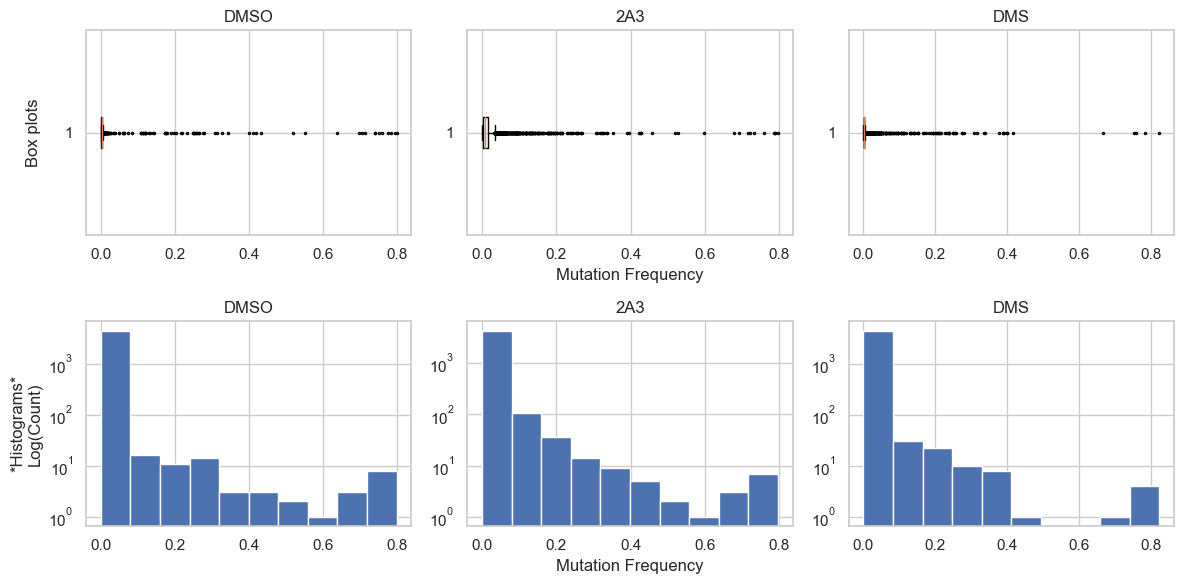

In [165]:
Q3df_DMSO=Big_df.loc[(Big_df['Compound']=='DMSO')]
Q3df_DMSO
Q3df_2A3=Big_df.loc[(Big_df['Compound']=='2A3')]
Q3df_2A3
Q3df_DMS=Big_df.loc[(Big_df['Compound']=='DMS')]
Q3df_DMS

fig, axes = plt.subplots(2,3,figsize = (12,6))

#boxplots
axes[0,0].boxplot(Q3df_DMSO['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[0,0].set_title('DMSO')
axes[0,1].boxplot(Q3df_2A3['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[0,1].set_title('2A3')
axes[0,2].boxplot(Q3df_DMS['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[0,2].set_title('DMS')
axes[0,1].set_xlabel('Mutation Frequency')
axes[0,0].set_ylabel('Box plots\n')

#histograms
axes[1,0].hist(Q3df_DMSO['Reactivity'])
axes[1,0].set_title('DMSO')
axes[1,0].set_yscale('log')
axes[1,1].hist(Q3df_2A3['Reactivity'])
axes[1,1].set_title('2A3')
axes[1,1].set_yscale('log')
axes[1,2].hist(Q3df_DMS['Reactivity'])
axes[1,2].set_title('DMS')
axes[1,2].set_yscale('log')
axes[1,0].set_ylabel('Histograms\nLog(Count)')
axes[1,1].set_xlabel('Mutation Frequency')



2A3 and DMS have nucleotide positions with higher mutation frequency realtive to DMSO, with 2A3 having the highest.

## Plot of mutation rate distribution *before* Winsorization


Individual distribution of mutation frequencies across nucleotides


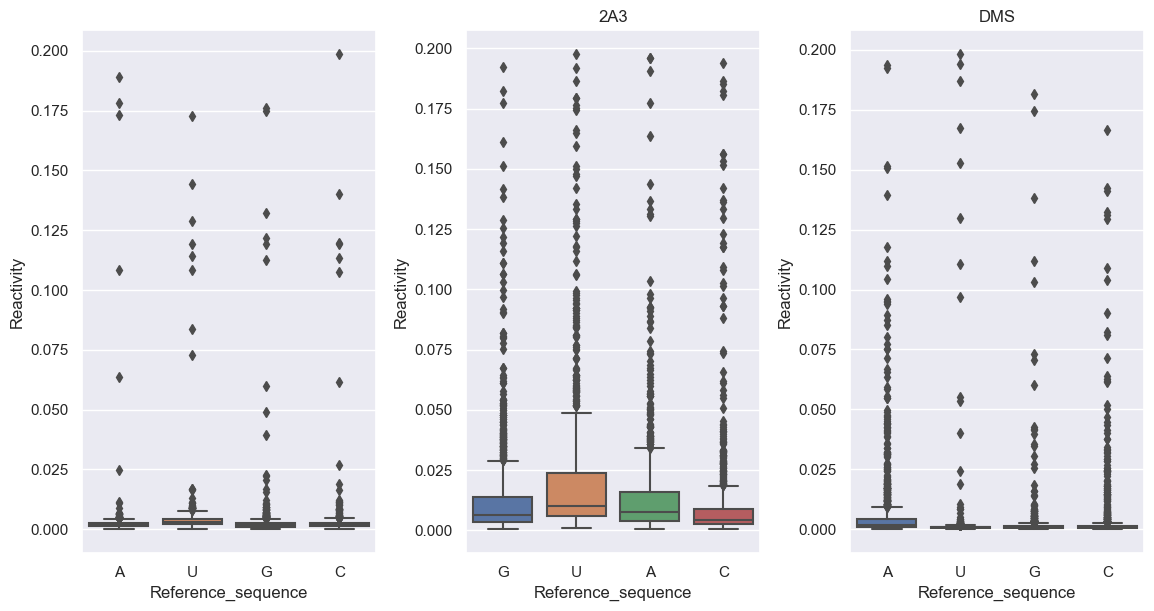

In [285]:
Q3df_DMSO=Big_df.loc[(Big_df['Compound']=='DMSO')]
Q3df_DMSO
Q3df_2A3=Big_df.loc[(Big_df['Compound']=='2A3')]
Q3df_2A3
Q3df_DMS=Big_df.loc[(Big_df['Compound']=='DMS')]
Q3df_DMS

sns.set(rc={'figure.figsize':(11.7,6.27)})

f, axes = plt.subplots(1, 3)

print('Individual distribution of mutation frequencies across nucleotides')
boxDMSO=sns.boxplot( y=Q3df_DMSO['Reactivity'], x= Q3df_DMSO['Reference_sequence'].replace('T','U'),  orient='v' , ax=axes[0])
box2A3=sns.boxplot(  y=Q3df_2A3['Reactivity'], x= Q3df_2A3['Reference_sequence'].replace('T','U'),  orient='v' , ax=axes[1]).set_title('2A3')
boxDMS=sns.boxplot(  y=Q3df_DMS['Reactivity'], x= Q3df_DMS['Reference_sequence'].replace('T','U'),  orient='v' , ax=axes[2]).set_title('DMS')


DMSO has very little reactivity.  The DMS sample demonstrates slightly higher reactivty on As and less on Cs.  However, 2A3 generates noticably stronger reactivity on all four bases,

### Plot of mutation rate distribution *following* Winsorization

Individual distribution of mutation frequencies across nucleotides following Normalization


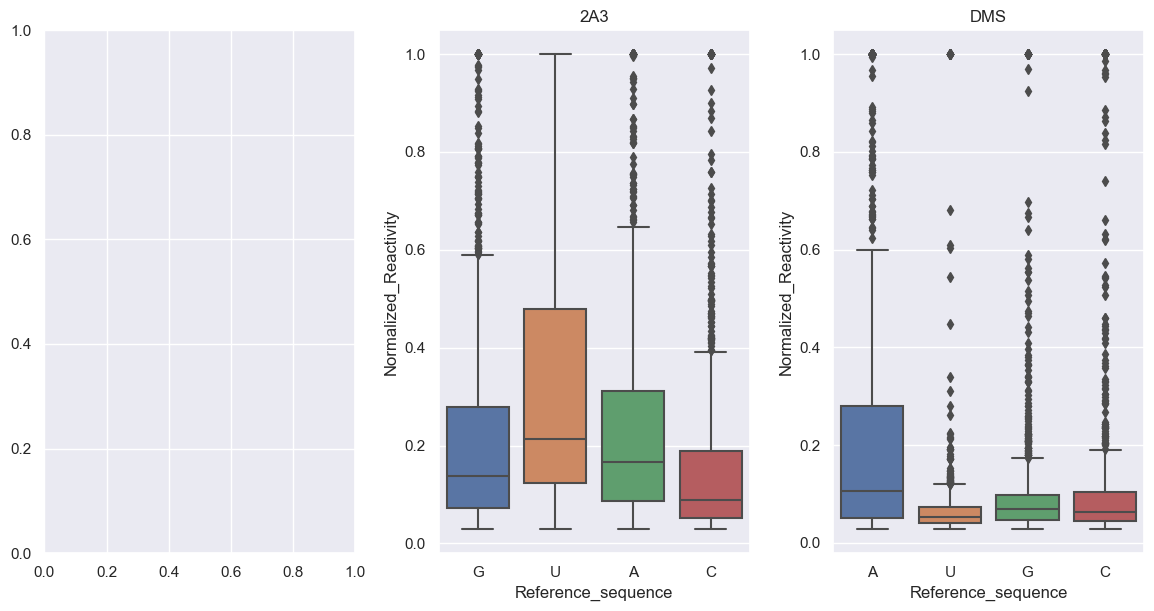

In [286]:
Q3df_DMSO=Big_df.loc[(Big_df['Compound']=='DMSO')]
Q3df_DMSO.dropna()
Q3df_2A3=Big_df.loc[(Big_df['Compound']=='2A3')]
Q3df_2A3.dropna()
Q3df_DMS=Big_df.loc[(Big_df['Compound']=='DMS')]
Q3df_DMS.dropna()

sns.set(rc={'figure.figsize':(11.7,6.27)})
f, axes = plt.subplots(1, 3)

print('Individual distribution of mutation frequencies across nucleotides following Normalization')
box2A3=sns.boxplot(  y=Q3df_2A3['Normalized_Reactivity'].astype(float), x= Q3df_2A3['Reference_sequence'].replace('T','U'),  orient='v' , ax=axes[1]).set_title('2A3')
boxDMS=sns.boxplot(  y=Q3df_DMS['Normalized_Reactivity'].astype(float), x= Q3df_DMS['Reference_sequence'].replace('T','U'),  orient='v' , ax=axes[2]).set_title('DMS')

When normalized to DMSO, the DMS sample demonstrates more measurable reactivty on As and less on Cs and Gs.  The 2A3 generates much stronger reactivity on all four bases.

### Plot the distribution of reactivities for the 3 reagents (DMSO, DMS, 2A3) among: <br>
* Unpaired bases<br>
* Base-paired bases residing next to unpaired bases (Terminal)<br>
* Base-pairs inside helices (Internal)


### Plot of reactivity distribution *before* normalization

Distribution of the reactivities of the three shape reagents before normalization


Text(0.5, 0, 'Mutation Frequency')

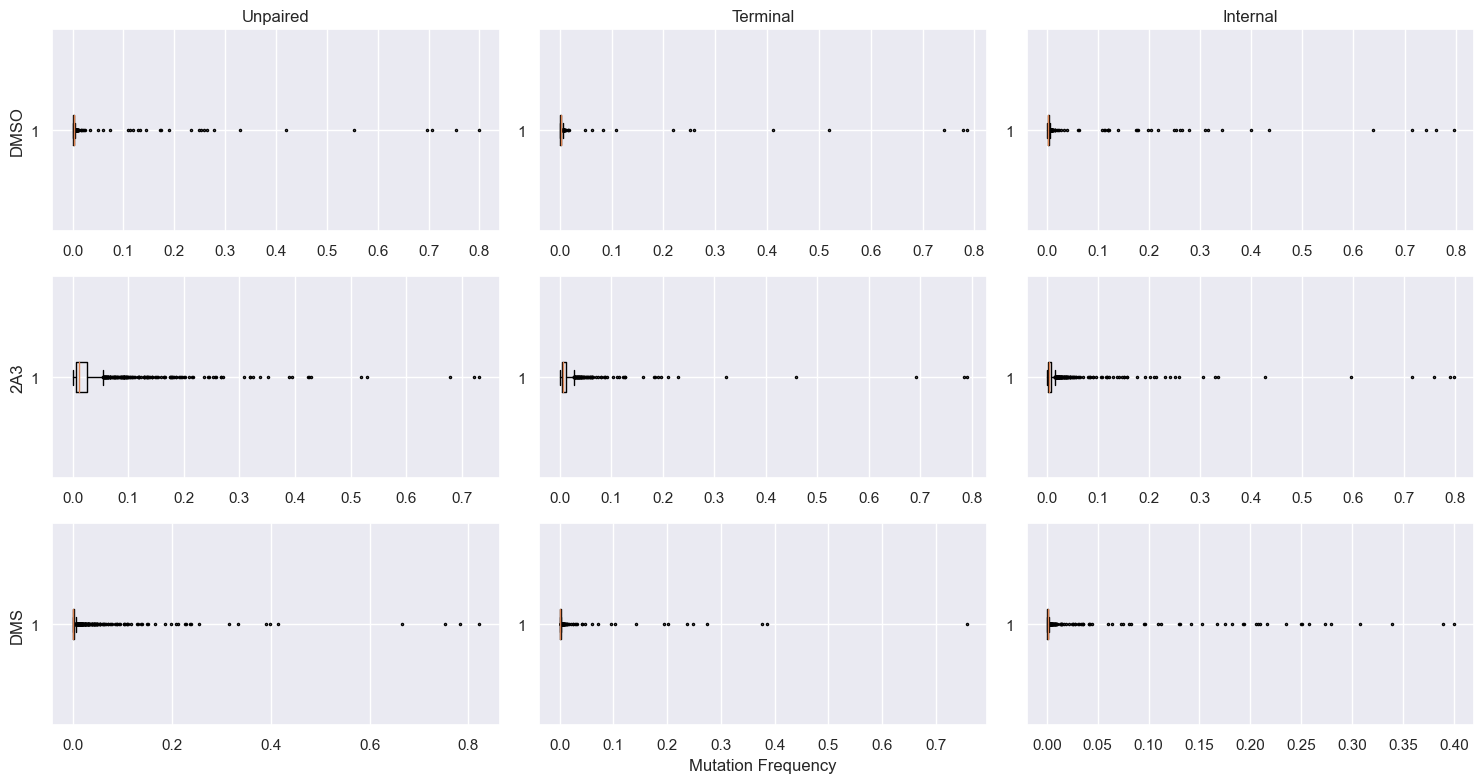

In [245]:
print('Distribution of the reactivities of the three shape reagents before normalization')
Q3df_DMSO=Big_df.loc[(Big_df['Compound']=='DMSO')]
Q3df_DMSO_U=Q3df_DMSO.loc[(Q3df_DMSO['Reference_psuedostructure']=='U')]
Q3df_DMSO_T=Q3df_DMSO.loc[(Q3df_DMSO['Reference_psuedostructure']=='T')]
Q3df_DMSO_I=Q3df_DMSO.loc[(Q3df_DMSO['Reference_psuedostructure']=='I')]

Q3df_2A3=Big_df.loc[(Big_df['Compound']=='2A3')]
Q3df_2A3_U=Q3df_2A3.loc[(Q3df_2A3['Reference_psuedostructure']=='U')]
Q3df_2A3_T=Q3df_2A3.loc[(Q3df_2A3['Reference_psuedostructure']=='T')]
Q3df_2A3_I=Q3df_2A3.loc[(Q3df_2A3['Reference_psuedostructure']=='I')]

Q3df_DMS=Big_df.loc[(Big_df['Compound']=='DMS')]
Q3df_DMS_U=Q3df_DMS.loc[(Q3df_DMS['Reference_psuedostructure']=='U')]
Q3df_DMS_T=Q3df_DMS.loc[(Q3df_DMS['Reference_psuedostructure']=='T')]
Q3df_DMS_I=Q3df_DMS.loc[(Q3df_DMS['Reference_psuedostructure']=='I')]

fig, axes = plt.subplots(3,3,figsize = (15,8))

#boxplots
axes[0,0].set_title('Unpaired')
axes[0,1].set_title('Terminal')
axes[0,2].set_title('Internal')
axes[0,0].set_ylabel('DMSO')
axes[1,0].set_ylabel('2A3')
axes[2,0].set_ylabel('DMS')

axes[0,0].boxplot(Q3df_DMSO_U['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[0,1].boxplot(Q3df_DMSO_T['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[0,2].boxplot(Q3df_DMSO_I['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[1,0].boxplot(Q3df_2A3_U ['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[1,1].boxplot(Q3df_2A3_T ['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[1,2].boxplot(Q3df_2A3_I ['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[2,0].boxplot(Q3df_DMS_U ['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[2,1].boxplot(Q3df_DMS_T ['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[2,2].boxplot(Q3df_DMS_I ['Reactivity'], vert=False, flierprops={'marker': '.', 'markersize': 3})

axes[2,1].set_xlabel('Mutation Frequency')


### Plot of distribution *after* normalization

Distribution of the reactivities of the three shape reagents after normalization


Text(0.5, 0, 'Mutation Frequency')

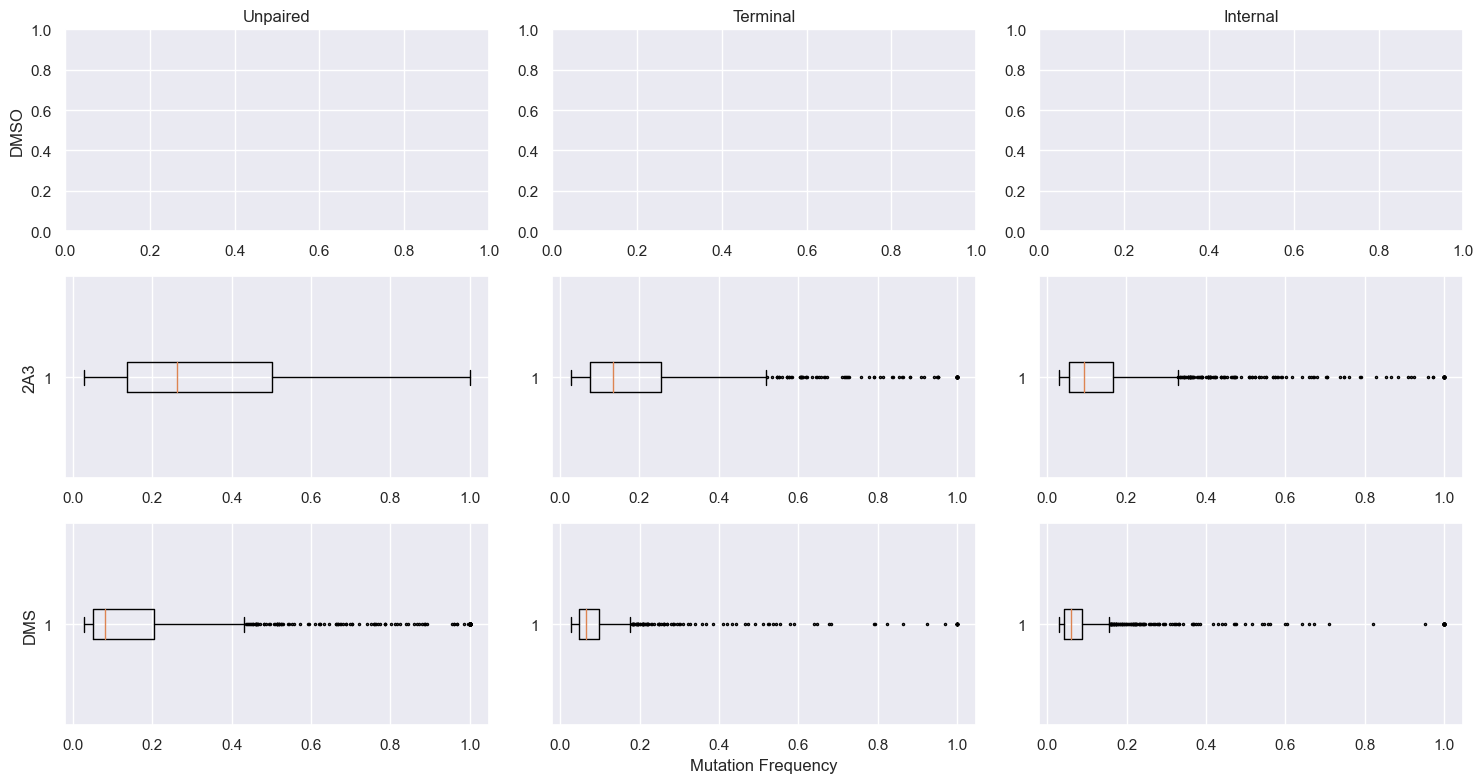

In [247]:
print('Distribution of the reactivities of the three shape reagents after normalization')
Q3df_DMSO=Big_df.loc[(Big_df['Compound']=='DMSO')].dropna()
Q3df_DMSO_U=Q3df_DMSO.loc[(Q3df_DMSO['Reference_psuedostructure']=='U')]
Q3df_DMSO_T=Q3df_DMSO.loc[(Q3df_DMSO['Reference_psuedostructure']=='T')]
Q3df_DMSO_I=Q3df_DMSO.loc[(Q3df_DMSO['Reference_psuedostructure']=='I')]

Q3df_2A3=Big_df.loc[(Big_df['Compound']=='2A3')].dropna()
Q3df_2A3_U=Q3df_2A3.loc[(Q3df_2A3['Reference_psuedostructure']=='U')]
Q3df_2A3_T=Q3df_2A3.loc[(Q3df_2A3['Reference_psuedostructure']=='T')]
Q3df_2A3_I=Q3df_2A3.loc[(Q3df_2A3['Reference_psuedostructure']=='I')]

Q3df_DMS=Big_df.loc[(Big_df['Compound']=='DMS')].dropna()
Q3df_DMS_U=Q3df_DMS.loc[(Q3df_DMS['Reference_psuedostructure']=='U')]
Q3df_DMS_T=Q3df_DMS.loc[(Q3df_DMS['Reference_psuedostructure']=='T')]
Q3df_DMS_I=Q3df_DMS.loc[(Q3df_DMS['Reference_psuedostructure']=='I')]

fig, axes = plt.subplots(3,3,figsize = (15,8))

#boxplots
axes[0,0].set_title('Unpaired')
axes[0,1].set_title('Terminal')
axes[0,2].set_title('Internal')
axes[0,0].set_ylabel('DMSO')
axes[1,0].set_ylabel('2A3')
axes[2,0].set_ylabel('DMS')


axes[1,0].boxplot(Q3df_2A3_U['Normalized_Reactivity'].astype(float).dropna(), vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[1,1].boxplot(Q3df_2A3_T['Normalized_Reactivity'].astype(float).dropna(), vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[1,2].boxplot(Q3df_2A3_I['Normalized_Reactivity'].astype(float).dropna(), vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[2,0].boxplot(Q3df_DMS_U['Normalized_Reactivity'].astype(float).dropna(), vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[2,1].boxplot(Q3df_DMS_T['Normalized_Reactivity'].astype(float).dropna(), vert=False, flierprops={'marker': '.', 'markersize': 3})
axes[2,2].boxplot(Q3df_DMS_I['Normalized_Reactivity'].astype(float).dropna(), vert=False, flierprops={'marker': '.', 'markersize': 3})

axes[2,1].set_xlabel('Mutation Frequency')


## ROC curves for the 3 reagents show the accuracy of compounds in capturing the structural state of the bases 
Unpaired bases are the True Positives, and base-paired bases are the True Negatives

In [ ]:
#import packages and prepare data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

#Prepare Normalized reactivity so it is a value rather than a string and simplify dataframe to relevant fields
Big_df['Normalized_Reactivity_float']=Big_df['Normalized_Reactivity'].astype(float)
Big_df= Big_df.dropna()
Big_df
Big_df_DMSO=Big_df.loc[(Big_df['Compound']=='DMSO')]
Big_df_2A3=Big_df.loc[(Big_df['Compound']=='2A3')]
Big_df_DMS=Big_df.loc[(Big_df['Compound']=='DMS')]

Select_df_DMSO = Big_df_DMSO[["Paired_state", "Normalized_Reactivity_float"]]
Select_df_2A3 = Big_df_2A3[["Paired_state", "Normalized_Reactivity_float"]]
Select_df_DMS = Big_df_DMS[["Paired_state", "Normalized_Reactivity_float"]]


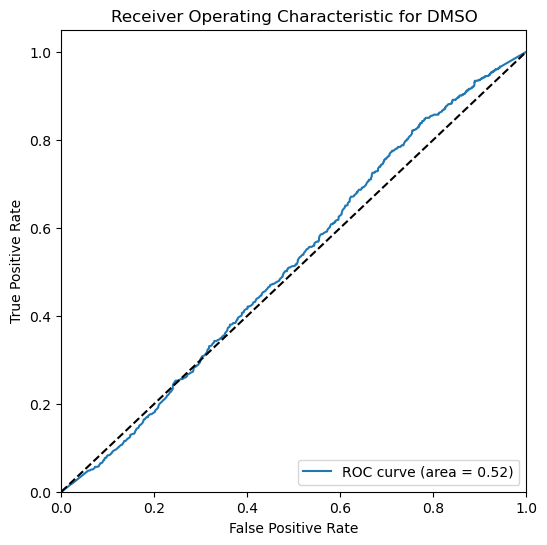

AUC: 0.52


In [176]:
#Perform training and testing of predictions for DMSO

df=Select_df_DMSO

# Split data into features and labels
X = df.drop(columns=['Paired_state'])
y = df['Paired_state'].astype(int)

# Split data into training and testing sets and set random state for reporoducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=33)

# Train a logistic regression classifier on the training data
classifier = LogisticRegression(random_state=33)
classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_score = classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR and TPR at different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, axes = plt.subplots(figsize = (6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for DMSO')
plt.legend(loc="lower right")
plt.savefig('ROC_of_DMSO.png')
plt.show()

print("AUC: %0.2f" % roc_auc)




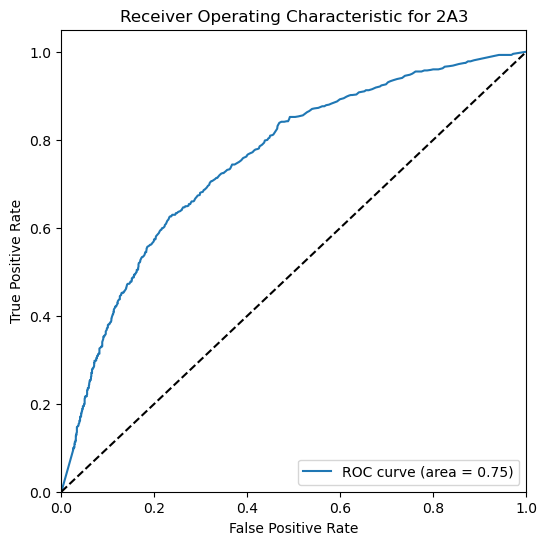

AUC: 0.75


In [177]:
#Perform training and testing of predictions for 2A3

df=Select_df_2A3

# Split data into features and labels
X = df.drop(columns=['Paired_state'])
y = df['Paired_state'].astype(int)

# Split data into training and testing sets and set random state for reporoducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=33)

# Train a logistic regression classifier on the training data
classifier = LogisticRegression(random_state=33)
classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_score = classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR and TPR at different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, axes = plt.subplots(figsize = (6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for 2A3')
plt.legend(loc="lower right")
plt.savefig('ROC_of_2A3.png')
plt.show()

print("AUC: %0.2f" % roc_auc)


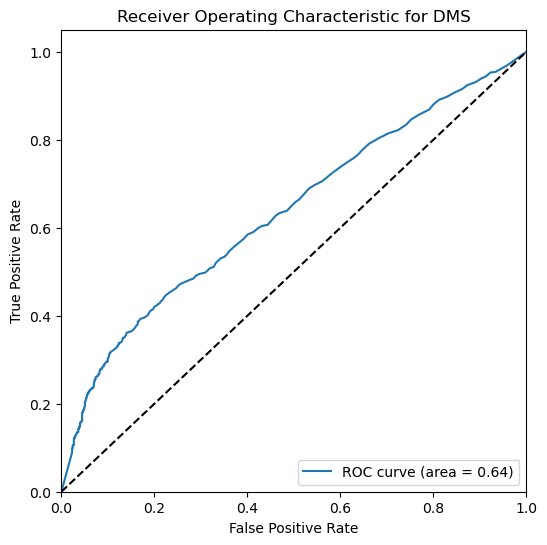

AUC: 0.64


In [178]:
#Perform training and testing of predictions for DMS

df=Select_df_DMS

# Split data into features and labels
X = df.drop(columns=['Paired_state'])
y = df['Paired_state'].astype(int)

# Split data into training and testing sets and set random state for reporoducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=33)

# Train a logistic regression classifier on the training data
classifier = LogisticRegression(random_state=33)
classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_score = classifier.predict_proba(X_test)[:, 1]

# Calculate the FPR and TPR at different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, axes = plt.subplots(figsize = (6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for DMS')
plt.legend(loc="lower right")
plt.savefig('ROC_of_DMS.png')
plt.show()

print("AUC: %0.2f" % roc_auc)


### Below is a  program to identify the start-end coordinates of each stem-loop structure in an RNA

In [164]:
import re

print("RNA\tStart\tStop\tMatch")

def rnasearch(rna_sequence, name):
    matchlist=[]
    matches = re.finditer(r'\(+\.+\)+', rna_sequence)

    for match in matches:
        difference=match.group().count("(")-match.group().count(")")

        if match.group().count("(")>match.group().count(")"):
            match_startpos= match.start()+difference+1
            matchlist.append((rna_sequence[match_startpos-1:match.end()], match_startpos, match.end()))
        elif match.group().count("(")<match.group().count(")"):
            match_endpos= match.end()+difference
            matchlist.append((rna_sequence[match.start():match_endpos],match.start()+1,match_endpos))
        else:
            matchlist.append((rna_sequence[match.start():match.end()], match.start()+1, match.end()))
    
    for item in matchlist:
        print(name,"\t",item[1],"\t", item[2], "\t", item[0],)

Structure_of_URS000039D89A=str("........((((.........))))(((((.((((((.(((((((((....(((.(((..(((..(((((..((((((((((....))))))).))))).))))))......(((......((((((((.((...(((((((.(((((...(((((((....)))))))....))))).(...(((....))).)..((((((..((....)))))))).)))))))..))))))))))(((..(.(((..((((((((.......))))))))))).....))))..((((((((....))))...))))))).((((((..........)))))).((((....))))...)))))))......(.(((...(((((....))))).)))).)).))))))..((((......((((....)))).....))))((((((((((((.(....((((((((.......)))))))).....)..))))))))))))..(((((......(((((((...((....)).....)))))))))))).)))))))))).)....(...(((.......((((...(((.(((((((.(((((((((((.....((((((.....))))))...)))))))))..)))))))))..((((((((((.((((((((((((((((((((((.(((......)))....))))))))))))))....(..((....)))))))))))))))).))))..))))...)))).(..(((((((...(...((((.........))))...))))))))..).......(((((((.((((((((((((.....))))))))))))..(((....)))...))))))).))))(((((.((.((((....)))))))))))........(((((.(((((((.((..((((((((((((((((((...)(((........))).........(((((((.....((((((((..(((((((....))))))).((((....))))))))).)))(((.((((..(((((((((.(.(((((((((....)))..((((......))))..)))))).....((((((((((((.((((..(((.....)))))))..)))))))..(..(((((.....))))).....).)))))...))))).)))...)))))))))...)))))))...)).)))))))))((..(((((((((..((((..((((.(((....))).))))....))))..)))))))))....).((((((((((((........))))))))))))..).)))))).(.((((((((((.......)))))))))))...))...)))))))))).))....((.((((.((((((((((((((((((((((....((((((.((((..((....)).))))))))))...))))))))))))))))))))))..))))..))....((((((((((....)))))))))).........................")
Structure_of_URS00019ABAEF=str(".........((((((((......((((((((((....((((..(((((((((((.......((((((((......)))).....(((((((..(((.......)))......)))))))...))))...(((....)))(((((((....))))))).(((((((((.........)))))))))......((((((..(((((....))..))).))))).).........((....))...(((((.....((.....))....)))))..((((..((((......(((((((((((((.(((...(((((......)))))........(((.......)))...)))...)))))))))))))...))))........(((((((((.......)))))))))......((((((....))))))..)))).....)).))))))).))...............((....))....)).........((((.....)))).............))....)))))))))).......((((((((((((....))))))))))))..((((........))))((((((....(((((((((((((..((((..((.....))..))))...((....)).(((((.....)))))....)))))))))))))..((.....((((((...((((((((((((.((((...(((((((....)))))))....))))...(((.(((((........))))))))..).))))))))))).(((.....)))......))))))........))..((((((....(((((....)))))..(((((((...(((((((((((((((((...((((((((...(((((((.....))))).))...))))))))..)).)))))))))))).)))...))))))).....((((((((((......))))))))))....(((......)))...((((.(((..((((......(.((((((...........(((.((((((((((.......(((((.((((((((.........)))))))).....(...((......)).).)))))...)))))))))))))...................)))))))))))..)))))))(((((((((....)))))))))....))))))..(((((((.(((......((((((((....))))))))...))))))))))........))))))((((.((((.....((((((.......))))))((((....((((..((..(((((((...((.....)).))))))......((((.((...(((.(.(((....))).).)))...))...(((((........)))))..(((((((((((((..((((((...((((..(((..(((((((((((..........))))))(((.((((...((((((((((((.((.....)))))))))))..)))...))))..))).(((((((....)))))))..)))))...)))...))))........))))))..))....))))))))))))))).))).....((......)).)))).((((.....))))..))))..((((....((((((((.(((((............(((((...((....))....)))))((((((...(((.....((((.....))))....)))..))))))(...).......(((((((((..(((.........)))..(((((((((...(((....)))...)..))))))))..((((.(((..(((((((..(((...((.(((((((..((......))...))))))).))...))))))))..)))))((((((.......))))))....................((((((.....))))))..........))))...)).)))))))..))))).)))))))).)))))))))))).....(((((........)))))..((((((((.(((.((......((((.(((((((.((((((((((((((..((((((((((((((((((.........(((((..(((......((((((((....))))))))...)))............)))))))))))))))))))))))...(((.((((((.....))))))))).....))))))))).)))))..(((((...)))))((((((...........))))))..((..((((((((((.((((((.......))))))...))..............))))))))..(((((((((......))))))))).(((....))).))..........(((((((.((........)))))))))............)))))..))))))......(((((.((((((((...((.......))...))))))))..))).)).......(((((((((((..((((((((((....))))))))..)).(((((.....))))).....)))))..)..)))).).....(((((((....))).))))....))..)))))))))))....((((((((..((((..(((((((...(((....)))..)))))))((((((...(((....(((((((((((....))))))..)))))....))).))))))..(((....(((((...........)))))....))).))))......))))))))..((((((...)))))).....(((((((((.......)))))....(((((((((((..(..(((((....))))))...))).))))).)))...)))).....))))))))....................")

rnasearch(example_sequence, "Example")
rnasearch(Structure_of_URS000039D89A, "E.coli_16S")
rnasearch(Structure_of_URS00019ABAEF, "E.coli_23S")



RNA	Start	Stop	Match
Example 	 27 	 41 	 (((((.....)))))
Example 	 63 	 77 	 (((((.....)))))
E.coli_16S 	 9 	 25 	 ((((.........))))
E.coli_16S 	 76 	 93 	 (((((((....)))))))
E.coli_16S 	 152 	 169 	 (((((((....)))))))
E.coli_16S 	 184 	 193 	 (((....)))
E.coli_16S 	 206 	 213 	 ((....))
E.coli_16S 	 252 	 274 	 ((((((((.......))))))))
E.coli_16S 	 293 	 304 	 ((((....))))
E.coli_16S 	 316 	 337 	 ((((((..........))))))
E.coli_16S 	 339 	 350 	 ((((....))))
E.coli_16S 	 375 	 388 	 (((((....)))))
E.coli_16S 	 416 	 427 	 ((((....))))
E.coli_16S 	 455 	 477 	 ((((((((.......))))))))
E.coli_16S 	 521 	 528 	 ((....))
E.coli_16S 	 612 	 628 	 ((((((.....))))))
E.coli_16S 	 688 	 699 	 (((......)))
E.coli_16S 	 725 	 732 	 ((....))
E.coli_16S 	 783 	 799 	 ((((.........))))
E.coli_16S 	 829 	 857 	 ((((((((((((.....))))))))))))
E.coli_16S 	 860 	 869 	 (((....)))
E.coli_16S 	 894 	 905 	 ((((....))))
E.coli_16S 	 956 	 960 	 (...)
E.coli_16S 	 961 	 974 	 (((........)))
E.coli_16S 	 1006 	

# Plots can be viewed interactively via Streamlit.  

To view on Streamlit, please run: 'streamlit run SHAPE_cpd_rRNA_analysis.py'
